In [2]:
import numpy as np
import math
import h5py
import matplotlib.pyplot as plt
import scipy.io
import time
import glob,os
#import cv2
from scipy import optimize
from skimage import feature
from pylab import *

from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.morphology import disk
from skimage.morphology import closing
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte

from hyperspy import io_plugins
from PIL import Image

def gaussKernel(sigma,imsize):
    x,y = np.meshgrid(range(1,imsize+1),range(1,imsize+1))
    x = x - imsize//2
    y = y - imsize//2
    tmp = -(x**2+y**2)/(2*sigma**2)
    return (1/(2*np.pi*sigma**2))*np.exp(tmp)

def map01(mat):
    return (mat - mat.min())/(mat.max() - mat.min())

# Figure 1
Figure: (a) synthetic BF and DF of STO; large scale image from Celeritas, with inset of DE-16 acquisition in the same time; (b) zoomed-in images of Celeritas and DE-16 covering the same field of view showing lower distortion in Celeritas data. Jingrui

For the same acquisition time, 1024x1024 Celeritas scan = 116x116 DE-16 scan. 

Rescale it with same step size, FOV = 116x7.3pm = 846.8pm, 846.8/19.6 = 43.2pos

FOV = 1024*7.3/

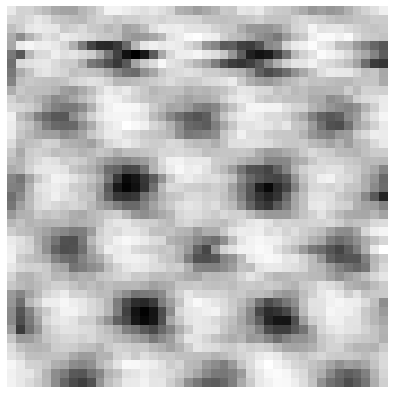

In [10]:
# Figure1a DE-16 BF
# scan step：19.6pm  

fig = plt.figure(figsize=(10,7))
sample = np.load('/srv/home/voyles/home-chenyu/DEbackup/2019/061219/S8/BF.npy')
#plt.imshow(sample[1:117,:116], cmap = 'gray')
plt.imshow(sample[1:44,:43], cmap = 'gray')
plt.axis('off')
#plt.colorbar()
fig.savefig('/srv/home/voyles/Papers/CeleritasCameraPaper/STO_imaging/Figure/BF1100fps.tif',dpi = 300,bbox_inches='tight', edgecolor='white')

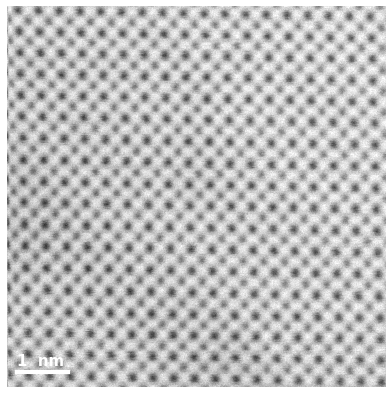

In [20]:
# Figure1a Celeritas BF
# scan step： 7.3pm
import h5py

with h5py.File('/srv/home/jwei74/4DSTEMdata/CeleritasTest/20210713/BF.h5','r') as F:
    sample = F['intensity']

    onenm = 1000/(14.6*512/1024)
    fig = plt.figure(figsize=(10,7))
    plt.imshow(sample[:,6:], cmap = 'gray', vmax = 940000)
    plt.plot([25,25+onenm],[985,985],linewidth=4, c = 'white')
    plt.text(90,953,'1  nm', c = 'white',fontsize = 15,horizontalalignment='center',verticalalignment='center', weight='bold')
    plt.axis('off')
    #plt.colorbar()
fig.savefig('/srv/home/voyles/Papers/CeleritasCameraPaper/STO_imaging/Figure/BF86000fps.tif',dpi = 300,bbox_inches='tight')

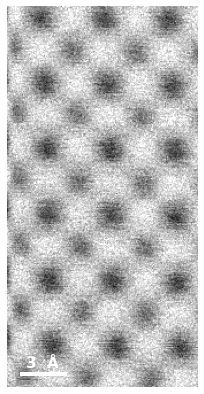

In [23]:
import h5py

with h5py.File('/srv/home/jwei74/4DSTEMdata/CeleritasTest/20210713/BF.h5','r') as F:
    sample = F['intensity']

    threeangstrom = 300/(8090/1024)
    fig = plt.figure(figsize=(10,7))
    plt.imshow(sample[1:333,6:172], cmap = 'gray', vmax = 940000)
    plt.plot([12,12+threeangstrom],[320,320],linewidth=4, c = 'white')
    plt.text(30,310,'3  \u212B', c = 'white',fontsize = 15,horizontalalignment='center',verticalalignment='center', weight = 'bold')
    plt.axis('off')
fig.savefig('/srv/home/voyles/Papers/CeleritasCameraPaper/STO_imaging/Figure/BF86000fpszoomin.tif',dpi = 400,bbox_inches='tight')

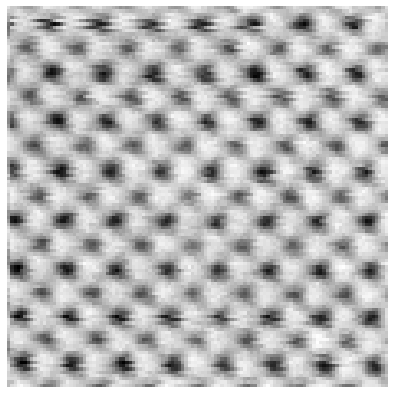

In [25]:
# Figure1a DE-16 BF
# scan step：19.6pm  

fig = plt.figure(figsize=(10,7))
sample = np.load('/srv/home/voyles/home-chenyu/DEbackup/2019/061219/S8/BF.npy')
#plt.imshow(sample[1:117,:116], cmap = 'gray')
plt.imshow(sample[1:117,:116], cmap = 'gray')
plt.axis('off')
#plt.colorbar()
fig.savefig('/srv/home/voyles/Papers/CeleritasCameraPaper/STO_imaging/Figure/BF1100fps_b.tif',dpi = 300,bbox_inches='tight', edgecolor='white')

# Figure2 Comparison of COM of STO

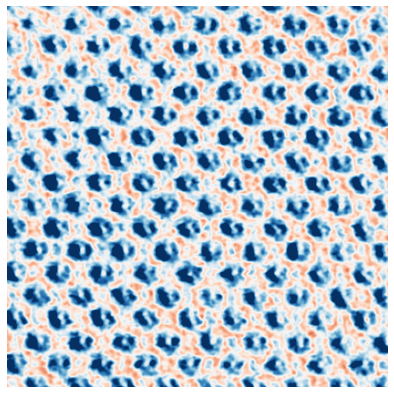

In [107]:
#Celeritas

from scipy.ndimage import gaussian_filter
sample = np.load('/srv/home/jwei74/4DSTEMdata/CeleritasTest/20210703/86000fpsSpot9/COM.npy')
fig = plt.figure(figsize=(10,7))
COM_exp_mag = np.sqrt(sample[:,:,0]**2 + sample[:,:,1]**2)
filtered  = gaussian_filter(COM_exp_mag,sigma = 1.2)
plt.imshow(filtered[-374:-30,-344:],cmap = 'RdBu',vmin = 0,vmax = 1.8)

plt.axis('off')
#plt.colorbar()
fig.savefig('/srv/home/voyles/Papers/CeleritasCameraPaper/STO_imaging/Figure/COMMag86000fps.tif',dpi = 300,bbox_inches='tight', edgecolor='white')

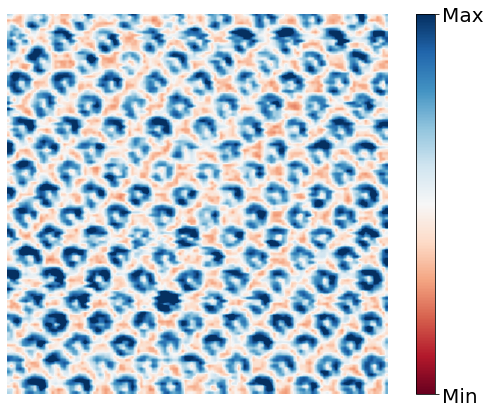

In [108]:
#DE-16
# fov 128x19.6 = 2.94nm
# 2940/7.3 = 403 pos
sample = np.load('/srv/home/voyles/home-chenyu/DEbackup/2019/061219/S8/COM.npy')
fig = plt.figure(figsize=(10,7))
COM_exp_mag = np.sqrt(sample[:,:,0]**2 + sample[:,:,1]**2)
filtered  = gaussian_filter(COM_exp_mag,sigma = 0.5)[20:-1,20:-1]
a = plt.imshow(filtered,cmap = 'RdBu', vmax =11, vmin = -3)
cbar = fig.colorbar(a)
cbar.set_ticks([-3,11])
cbar.set_ticklabels(['Min', 'Max'])
cbar.ax.tick_params(labelsize=20) 
plt.axis('off')
fig.savefig('/srv/home/voyles/Papers/CeleritasCameraPaper/STO_imaging/Figure/COMMag1100fps.tif',dpi = 300,bbox_inches='tight', edgecolor='white')

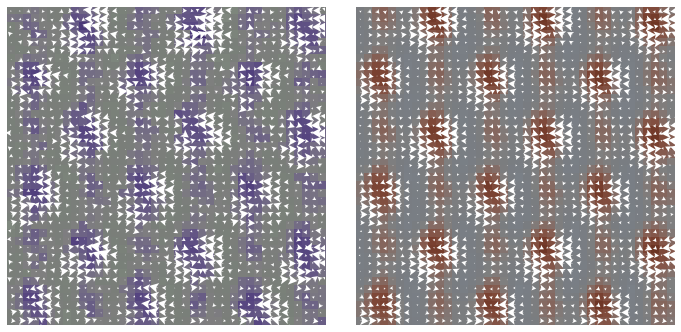

In [102]:
%matplotlib inline

from empyre.vis.colors import Colormap3D
from empyre.vis.colors import ColormapCubehelix
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig0, ax0 = plt.subplots(nrows=1, ncols=2, figsize = (10,8))
fig0.tight_layout(h_pad = .1, w_pad = 0)
ax0[0].axis('off') 
ax0[1].axis('off')

# scan step 7.9pm bin2 get 15.8
with h5py.File('/srv/home/jwei74/4DSTEMdata/20210920STOthin/movie217/comfc1.h5', 'r') as F:
    N = 90
    Fx = F['x'][10:N, 10:N]
    Fy = F['y'][10:N, 10:N]
    Fx = scipy.ndimage.interpolation.zoom(Fx,0.5)
    Fy = scipy.ndimage.interpolation.zoom(Fy,0.5)
    commag = np.sqrt(Fx**2 + Fy**2)
    nrows, ncols = Fx.shape
    x = np.linspace(0, ncols, ncols)
    y = np.linspace(0, ncols, nrows)
    xi, yi = np.meshgrid(x, y)

    color = np.sqrt(Fx**2 + Fy**2)

    ax0[0].quiver(xi, yi, Fx, Fy, color = 'w',  headwidth= 21,headlength= 19,headaxislength = 15)
    from empyre.vis.colors import ColormapCubehelix
    ch = ColormapCubehelix(start=0, rot=0, minLight=-0.1, maxLight=1.5, sat=13)
    
    #divergence =  np.gradient(Fx, axis=0) + np.gradient(Fy, axis=1)
    curl_2d = np.gradient(Fx, axis=1) - np.gradient(Fy, axis=0)

    ax0[0].imshow(ch.rgb_from_vector((curl_2d, 0, curl_2d)))

    

# scan step 14.6pm 
threeangstrom = 300/14.6

with h5py.File('/srv/home/voyles/Papers/CeleritasCameraPaper/NRR_5DSTEM/com.h5', 'r') as F:
    N = 90
    Fx = F['x'][10:N, 10:N]
    Fy = F['y'][10:N, 10:N]
    Fx = scipy.ndimage.interpolation.zoom(Fx,0.5)
    Fy = scipy.ndimage.interpolation.zoom(Fy,0.5)
    commag = np.sqrt(Fx**2 + Fy**2)
    nrows, ncols = Fx.shape
    x = np.linspace(0, ncols, ncols)
    y = np.linspace(0, ncols, nrows)
    xi, yi = np.meshgrid(x, y)

    color = np.sqrt(Fx**2 + Fy**2)

    ax0[1].quiver(xi, yi, Fx, Fy, color = 'w',  headwidth= 21,headlength= 19,headaxislength = 15)
    from empyre.vis.colors import ColormapCubehelix
    ch = ColormapCubehelix(start=1, rot=0, minLight=-0.1, maxLight=1.5, sat=5)
    
    #divergence =  np.gradient(Fx, axis=0) + np.gradient(Fy, axis=1)
    curl_2d = np.gradient(Fx, axis=1) - np.gradient(Fy, axis=0)

    ax0[1].imshow(ch.rgb_from_vector((curl_2d, 0, curl_2d)))


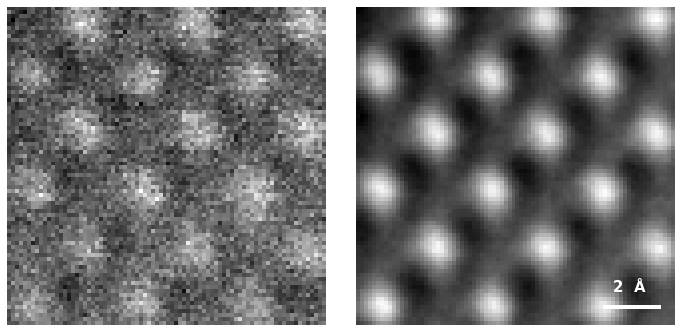

In [129]:
fig0, ax0 = plt.subplots(nrows=1, ncols=2, figsize = (10,8))
fig0.tight_layout(h_pad = .1, w_pad = 0)
ax0[0].axis('off') 
ax0[1].axis('off')
# scan step 14.6pm 
twoangstrom = 200/14.6

with h5py.File('/srv/home/voyles/Papers/CeleritasCameraPaper/NRR_5DSTEM/Rawdata/movie217/ADFfc1.h5', 'r') as F:
    N = 90
    img = F['intensity'][10:N,10:N]
    ax0[0].imshow(img, cmap = 'gray')

    
with h5py.File('/srv/home/voyles/Papers/CeleritasCameraPaper/NRR_5DSTEM/ADF.h5', 'r') as F:
    N = 90
    img = F['intensity'][10:N,10:N]
    ax0[1].imshow(img, cmap = 'gray')
    ax0[1].plot([62,62+twoangstrom],[75,75],linewidth=4, c = 'white')
    ax0[1].text(68,70,'2  \u212B', c = 'white',fontsize = 15,horizontalalignment='center',verticalalignment='center', weight = 'bold')
